# The difficulties that sample-average methods have for nonstationary problems
Experiment method:

* use a modified version of the 10-armed testbed in which all the q_*(a) start out equal
* then take indepedent random walks (add N(0,0.01) each step
* implement an action-value method using sample averages, we call this method 'subject'
* implement an action-value method using a constant step-size parameter alpha=0.1, we call this method 'alternative'
* both methods will use epsilon 0.1  and 10000 steps
* Plot Average rewards
* Plot % Optimal action



In [55]:
# -*- coding: utf-8 -*-
# This file is a Module to support Trials for non-stationary 10-armed testbed 

import numpy as np
import matplotlib.pyplot as plt

class Trial:
    """Support the data intialization, experiment simulation and plottings of target trials.
    Arguments:
        n: A natural number n for number of arms in testbed. defaut 10
        walk_variance: positive float for variance of random walk. default 0.01
        epsilon: a float between 0 and 1. Probability for exploration. default 0.1
        step_size: a float. step_size of incremental update in alternative method. default 0.1
        steps: number to steps to run in this trial. default 10000
    Attributes:
        n: A natural number n for number of arms in testbed. defaut 10
        walk_variance: positive float for variance of random walk. default 0.01
        epsilon: a float between 0 and 1. Probability for exploration. default 0.1
        step_size: a float. step_size of incremental update in alternative method. default 0.1
        steps: number to steps to run in this trial. default 10000
        count: number of steps trial has run. initialized to be 0
        test_bed: A numpy array of float, dimension n*(steps+1). initialized to be all 0
        subject_estimates: A numpy array of float, dimension n. initialized to be all 0
        subject_step_counts: A numpy array of integers, dimension n. initialized to be all 0
        subject_mean_rewards: A numpy array of float, dimension steps+1. initialized to be all 0
        subject_optimal_perc:  A numpy array of float, dimension steps+1. initialized to be all 0
        alternative_estimates: A numpy array of float, dimension n. initialized to be all 0
        alternative_mean_rewards: A numpy array of float, dimension steps+1. initialized to be all 0 
        alternative_optimal_perc:  A numpy array of float, dimension steps+1. initialized to be all 0
    """

    def __init__(self,n=10,walk_variance=0.01,epsilon=0.1,step_size=0.1,steps=10000):
        self.count = 0 ## number of trials have run
        self.n = n
        self.walk_variance = walk_variance
        self.epsilon = epsilon
        self.step_size = step_size
        self.steps = steps
        self.test_bed =np.zeros((n,steps+1)) ## The last column is unused
        self.subject_estimates = np.zeros((n,))
        self.subject_step_counts =  np.zeros((n,))
        self.subject_mean_rewards = np.zeros((steps+1,))
        self.subject_optimal_perc = np.zeros((steps+1,))
        self.alternative_estimates = np.zeros((n,))
        self.alternative_mean_rewards = np.zeros((steps+1,))
        self.alternative_optimal_perc = np.zeros((steps+1,))
        
    def run(self):
        ## run the experiments
        while self.count<self.steps:
            self.walk()
        ## create the plots
        self.plot_avg()
        self.plot_opt()
        
    def walk(self):
        """This function simulates one step in the trial"""
        ## Update test_bed, note that we could also update test_bed later, but I prefer this way
        self.testbed_update()
        ## subject walk one step
        self.subject_walk()
        ## alternative walk one step
        self.alternative_walk()
        ## update count number
        self.count +=1
        
    def testbed_update(self):
        """This function simulates one step of testbed update"""
        increments = np.random.normal(loc=0,scale=self.walk_variance,size=(self.n,))
        self.test_bed[:,self.count+1] = self.test_bed[:,self.count] + increments
    
    def attempt(self,estimates):
        """This function simulates actions of methods before reward updates."""
        if np.random.rand(1)[0] < self.epsilon: ## explore!
            selected = np.random.randint(low=0,high=self.n,size=1)[0] ## explore any arm
        else: ## exploit!
            selected = np.argmax(estimates) ## exploit best option
        ## get reward for this selection: R is a gaussian with mean q_*(a) and variance 1
        reward_mean = self.test_bed[selected,self.count]
        R = np.random.normal(loc=reward_mean,scale=1,size=1)[0]
        optimal = np.argmax(self.test_bed[:,self.count])
        optimal_selected = int(optimal == selected)
        return selected, R, optimal_selected
    
    @staticmethod
    def update_step(num,step_size,R):
        return num + step_size * (R - num)
    
    def subject_walk(self):
        """This function simulates one step of subject walk"""
        selected, R,optimal_selected = self.attempt(self.subject_estimates)
        ## Record mean reward
        self.subject_mean_rewards[self.count+1] = Trial.update_step(self.subject_mean_rewards[self.count]
                                                         ,1/(1+self.count),R)
        ## Record percentage of optimal options
        self.subject_optimal_perc[self.count+1] = Trial.update_step(self.subject_optimal_perc[self.count]
                                                              ,1/(1+self.count),optimal_selected)
        ## Update estimates : key difference between subject and alternative
        self.subject_step_counts[selected] += 1
        self.subject_estimates[selected] = Trial.update_step(self.subject_estimates[selected],
                                                       1/(1+self.subject_step_counts[selected]),R)
    def alternative_walk(self):
        """This function simulates one step of alternative walk"""
        selected, R,optimal_selected = self.attempt(self.alternative_estimates)
        ## Record mean reward
        self.alternative_mean_rewards[self.count+1] = Trial.update_step(self.alternative_mean_rewards[self.count]
                                                             ,1/(1+self.count),R)
        ## Record percentage of optimal options
        self.alternative_optimal_perc[self.count+1] = Trial.update_step(self.alternative_optimal_perc[self.count]
                                                             ,1/(1+self.count),optimal_selected) 
        ## Update estimates : key difference between subject and alternative
        self.alternative_estimates[selected] = Trial.update_step(self.alternative_estimates[selected]
                                                             ,self.step_size,R)
    def plot_avg(self):
        steps = [*range(self.steps+1)]
        with plt.style.context('Solarize_Light2'):
            plt.plot(steps,self.subject_mean_rewards,label = 'subject')
            plt.plot(steps,self.alternative_mean_rewards,label = 'alternative')
            plt.legend()
            plt.xlabel("Steps")
            plt.ylabel("Average reward")
        plt.show()
    
    def plot_opt(self):
        steps = [*range(self.steps+1)]
        with plt.style.context('Solarize_Light2'):
            plt.plot(steps,self.subject_optimal_perc,label = 'subject')
            plt.plot(steps,self.alternative_optimal_perc,label = 'alternative')
            plt.legend()
            plt.xlabel('Steps')
            plt.ylabel('% Optional action')
        plt.show()

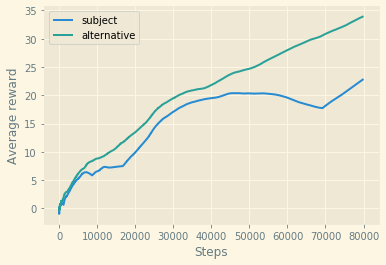

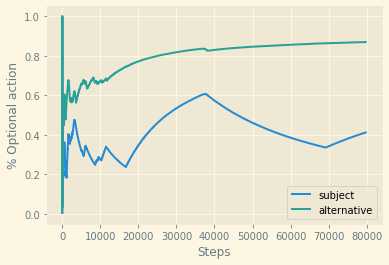

In [60]:
t = Trial(walk_variance=0.1,step_size=0.1,epsilon=0.1,steps=80000)
t.run()

# Conclusion
We can tune different parameters, and it seems that larger the steps, weaker subject compared to alternative.